In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))
import numpy as np
import matplotlib.pyplot as plt
import pandas
import VBBinaryLensing
import MulensModel as mm
from scipy.optimize import minimize, fmin

from multiprocessing import Pool

from tqdm import tqdm
np.random.seed(0)

def get_fsfb(amp, flux, ferr):
    sig2 = ferr**2
    wght = flux/sig2
    d = np.ones(2)
    d[0] = np.sum(wght*amp)
    d[1] = np.sum(wght)
    b = np.zeros((2,2))
    b[0,0] = np.sum(amp**2/sig2)
    b[0,1] = np.sum(amp/sig2)
    b[1,0] = b[0,1]
    b[1,1] = np.sum(1./sig2)
    c = np.linalg.inv(b)
    fs = np.sum(c[0]*d)
    fb = np.sum(c[1]*d)
    fserr = np.sqrt(c[0,0])
    fberr = np.sqrt(c[1,1])
    fmod = fs*amp+fb
    chi2 = np.sum((flux-fmod)**2/sig2)
    return chi2,fs,fb,fserr,fberr

counter=0
def compute_model_lc(time_array, fitting_parameters, VBBL):
    global counter
    u0, lgq, lgs, ad180 = fitting_parameters
    q, s = 10**lgq, 10**lgs
    alpha = ad180 * np.pi # convert to radian
    t0, te, rho = 0, 1, 1e-3
    tau = (time_array-t0)/te
    xs = tau*np.cos(alpha) - u0*np.sin(alpha)
    ys = tau*np.sin(alpha) + u0*np.cos(alpha)
    # np.random.seed(0)
    # if counter == 1324:
    #     for i in range(len(xs)):
    #         print(i, (s, q, xs[i], ys[i], rho))
    #         VBBL.BinaryMag2(s, q, xs[i], ys[i], rho)
    magnifications = np.array([VBBL.BinaryMag2(s, q, xs[i], ys[i], rho) for i in range(len(xs))])
    counter += 1
    print(f'VBBL{counter}')
    return magnifications

def perform_optimization(time, flux, ferr, para_initial, verbose=True):
    VBBL = VBBinaryLensing.VBBinaryLensing()
    
    def compute_chisq(fitting_parameters, time, flux, ferr, VBBL, return_model=False):
        magnifications = compute_model_lc(time, fitting_parameters, VBBL)
        chi2, fs, fb, fserr, fberr = get_fsfb(magnifications, flux, ferr)
        if return_model:
            return chi2, fs, fb
        return chi2

    # res = minimize(compute_chisq, para_initial, args=(time, flux, ferr, VBBL), method='Powell', options={'maxiter': 1000, 'maxfev': 1000, 'disp': verbose})
    # para_best = res.x
    # chi2_min = res.fun
    # iter = res.nit
    # funcals = res.nfev
    # warnflag = res.status
    para_best, chi2_min, iter, funcalls, warnflag, allevcs = fmin(compute_chisq, para_initial, args=(time, flux, ferr, VBBL), full_output=True, retall=True, maxiter=1000, maxfun=1000, disp=verbose)

    chi2_min, fs, fb = compute_chisq(para_initial, time, flux, ferr, VBBL, return_model=True)
    if verbose:
        print('initial chisq: ', chi2_min)
    chi2_min, fs, fb = compute_chisq(para_best, time, flux, ferr, VBBL, return_model=True)
    if verbose:
        print('best chisq & (fs, fb): ', chi2_min, fs, fb)
    time_model = np.arange(-2, 2, 0.001)
#    magnifications = compute_model_lc(time_model, para_initial, VBBL)
    magnifications = compute_model_lc(time_model, para_best, VBBL)
    mag_model = 18 - 2.5*np.log10(magnifications*fs + fb)
    model = np.vstack((time_model, mag_model))
    return para_best, chi2_min, model, warnflag

def get_best_params(lc, locs, n_gau, verbose=False, message=None):
    size = len(lc)
    best_parameters = np.zeros((size, n_gau, 6))
    for i in tqdm(range(size)):
        for index in range(n_gau):
            para_initial = locs[i, index, :-1]
            if verbose:
                print(para_initial)
            para_best, chi2_min, model, warnflag = perform_optimization(lc[i, :, 0], lc[i, :, 2], lc[i, :, 3], para_initial, verbose=verbose)
            best_parameters[i, index] = np.hstack((chi2_min, warnflag, para_best))
    print(f'# {message} done!')
    return best_parameters

In [2]:
# input_file = np.load('/work/hmzhao/opt_input_300.npz')
# lc = input_file['lc']
# locs = input_file['locs']

# verbose = False

In [3]:
# lc = lc[[6677]]
# locs = locs[[6677]]

In [4]:
# np.savez('./opt_loop.npz', lc=lc, locs=locs)

In [5]:
lc = np.load('./opt_loop.npz')['lc']
locs = np.load('./opt_loop.npz')['locs']

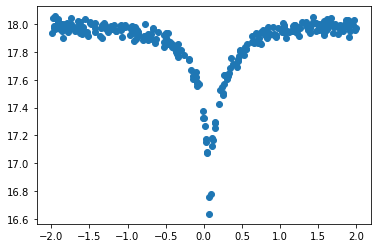

In [6]:
plt.scatter(lc[0, :, 0], lc[0, :, 1])
plt.show()

In [7]:
import profile

In [9]:
profile.run("_=get_best_params(lc, locs, 4, True)")

  0%|          | 0/1 [00:00<?, ?it/s]

[ 0.12669614 -1.073024    0.2284537   0.87454504]
VBBL1
VBBL2
VBBL3
VBBL4
VBBL5
VBBL6
VBBL7
VBBL8
VBBL9
VBBL10
VBBL11
VBBL12
VBBL13
VBBL14
VBBL15
VBBL16
VBBL17
VBBL18
VBBL19
VBBL20
VBBL21
VBBL22
VBBL23
VBBL24
VBBL25
VBBL26
VBBL27
VBBL28
VBBL29
VBBL30
VBBL31
VBBL32
VBBL33
VBBL34
VBBL35
VBBL36
VBBL37
VBBL38
VBBL39
VBBL40
VBBL41
VBBL42
VBBL43
VBBL44
VBBL45
VBBL46
VBBL47
VBBL48
VBBL49
VBBL50
VBBL51
VBBL52
VBBL53
VBBL54
VBBL55
VBBL56
VBBL57
VBBL58
VBBL59
VBBL60
VBBL61
VBBL62
VBBL63
VBBL64
VBBL65
VBBL66
VBBL67
VBBL68
VBBL69
VBBL70
VBBL71
VBBL72
VBBL73
VBBL74
VBBL75
VBBL76
VBBL77
VBBL78
VBBL79
VBBL80
VBBL81
VBBL82
VBBL83
VBBL84
VBBL85
VBBL86
VBBL87
VBBL88
VBBL89
VBBL90
VBBL91
VBBL92
VBBL93
VBBL94
VBBL95
VBBL96
VBBL97
VBBL98
VBBL99
VBBL100
VBBL101
VBBL102
VBBL103
VBBL104
VBBL105
VBBL106
VBBL107
VBBL108
VBBL109
VBBL110
VBBL111
VBBL112
VBBL113
VBBL114
VBBL115
VBBL116
VBBL117
VBBL118
VBBL119
VBBL120
VBBL121
VBBL122
VBBL123
VBBL124
VBBL125
VBBL126
VBBL127
VBBL128
VBBL129
VBBL130
VBBL131
VBBL132
VB

In [6]:
VBBinaryLensing.VBBinaryLensing().BinaryMag2(*(3.876796898432874, 0.40591187572538584, -0.8283602850831543, -1.6900342579978447, 0.001))

1.0541590825995781